# Summarize performance of different backend applications

Possible options:
* Local server - running locally with `make run` on same machine as tests.
* Docker server - running locally with `make docker-run` on same machine as tests.


## How performance measurments are done

Run two terminal on testing machine.

In terminal 1 run backend server:
```bash
# cd to backend app folder, example:
cd ~/prj/vscar/back/vscar-back-fastapi/

# for local server
make run
# for docker server
make docker-run
```

In terminal 2 run performance tests:
```bash
cd ~/prj/vscar/tests/
# use run-perf-back-% target, example:
make run-perf-back-fastapi
```

Repeat for other apps

This will put csv files with measurments into `perf_test/data` folder.
If both local and docker results are needed:
* run first time for local then move manually csv files from `perf_test/data/*.csv` to `perf_test/data/local/*.csv`
    ```bash
    mv perf_test/data/*.csv perf_test/data/local/
    ```
* run second time for docker then move manually csv files from `perf_test/data/*.csv` to `perf_test/data/docker/*.csv`
    ```bash
    mv perf_test/data/*.csv perf_test/data/local/
    ```

After that run this notebook.

### Build all backend docker images

Run:
```bash
make images-build
```

Backend docker images:
```bash
make images-show
docker images | grep "REPOSITORY\|vscar-back" | sort -k7 -h
REPOSITORY                                 TAG                        IMAGE ID       CREATED        SIZE
vscar-back-gin-app                         latest                     5933ec5524e5   2 hours ago    94.6MB
vscar-back-rocket-app                      latest                     d40bcf699b46   35 hours ago   96.8MB
vscar-back-fastapi-app                     latest                     6916df15dfe2   2 hours ago    180MB
vscar-back-ktor-app                        latest                     9490a90968ad   55 years ago   228MB
vscar-back-spring-app                      latest                     f1aa90837daa   45 years ago   274MB
vscar-back-nestjs-app                      latest                     ba870039db6a   28 hours ago   443MB
```


In [77]:
from pathlib import Path

import pandas as pd
import seaborn as sns

folder = Path("data/")
assert folder.exists() and folder.is_dir()  # noqa: PT018, S101
csvs = list(folder.glob("**/vscar*.csv"))

dfs = []
for csv in csvs:
    df_csv = pd.read_csv(csv)
    if csv.parent.name != "data":
        df_csv["server"] = csv.parent.name
    dfs.append(df_csv)

df = pd.concat(dfs)

df.head()

,Unnamed: 0,test_type,app,exec_time,response_code,request_data,parallel,server
0,0,loop_through_pages,vscar-back-rocket,234.092474,200,"{'page': 1, 'limit': 100, 'text': '', 'attribu...",False,docker
1,1,loop_through_pages,vscar-back-rocket,244.316578,200,"{'page': 2, 'limit': 100, 'text': '', 'attribu...",False,docker
2,2,loop_through_pages,vscar-back-rocket,186.953306,200,"{'page': 3, 'limit': 100, 'text': '', 'attribu...",False,docker
3,3,loop_through_pages,vscar-back-rocket,237.389803,200,"{'page': 4, 'limit': 100, 'text': '', 'attribu...",False,docker
4,4,loop_through_pages,vscar-back-rocket,185.903788,200,"{'page': 5, 'limit': 100, 'text': '', 'attribu...",False,docker


# Check for code responses

In [78]:
df["response_code"].unique()

array([200, 201])

In [79]:
df_avg = df.groupby(["test_type", "app", "parallel", "server"])["exec_time"].mean().reset_index()
df_avg.head()

,test_type,app,parallel,server,exec_time
0,loop_through_pages,vscar-back-fastapi,False,docker,403.913450
1,loop_through_pages,vscar-back-fastapi,False,local,353.052215
2,loop_through_pages,vscar-back-fastapi,True,docker,1152.463464
3,loop_through_pages,vscar-back-fastapi,True,local,1004.309392
4,loop_through_pages,vscar-back-gin,False,docker,164.164225


In [80]:
def plot_and_print(test_type: str, *, parallel: bool) -> None:
    """Plot and pring data."""
    df_tt = df_avg[(df_avg["test_type"] == test_type) & (df_avg["parallel"] == parallel)]

    g = sns.catplot(
        data=df_tt, kind="bar",
        x="app", y="exec_time", hue="server",
        errorbar="sd", palette="dark", alpha=.6, height=6
    )
    g.despine(left=True)
    g.set_axis_labels("app", "Execution Time (ms)")
    g.legend.set_title("")
    g.set_xticklabels(rotation=45, ha='right')

    print(f"\nData for '{test_type}' Test Type:\n")  # noqa: T201
    print(df_tt.sort_values(["server", "app"]).to_string(index=False))  # noqa: T201




## Base on loop_through_pages


Data for 'loop_through_pages' Test Type:

         test_type                app  parallel server  exec_time
loop_through_pages vscar-back-fastapi     False docker 403.913450
loop_through_pages     vscar-back-gin     False docker 164.164225
loop_through_pages    vscar-back-ktor     False docker 154.764752
loop_through_pages  vscar-back-nestjs     False docker 145.649413
loop_through_pages  vscar-back-rocket     False docker 167.056616
loop_through_pages  vscar-back-spring     False docker 150.387577
loop_through_pages vscar-back-fastapi     False  local 353.052215
loop_through_pages     vscar-back-gin     False  local 163.675201
loop_through_pages    vscar-back-ktor     False  local 151.728924
loop_through_pages  vscar-back-nestjs     False  local 137.343117
loop_through_pages  vscar-back-rocket     False  local 167.076409
loop_through_pages  vscar-back-spring     False  local 214.850787


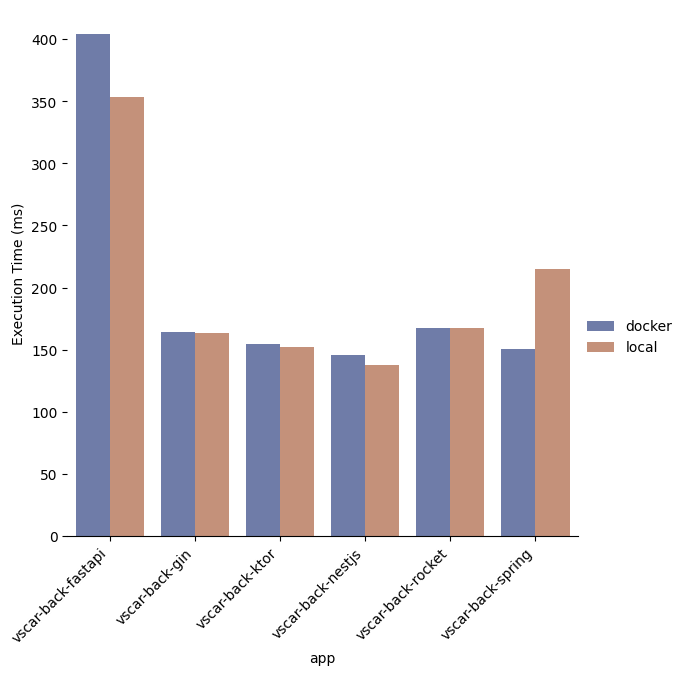

In [81]:
plot_and_print("loop_through_pages", parallel=False)


Data for 'loop_through_pages' Test Type:

         test_type                app  parallel server   exec_time
loop_through_pages vscar-back-fastapi      True docker 1152.463464
loop_through_pages     vscar-back-gin      True docker  463.196735
loop_through_pages    vscar-back-ktor      True docker  402.920286
loop_through_pages  vscar-back-nestjs      True docker  681.592051
loop_through_pages  vscar-back-rocket      True docker  462.323829
loop_through_pages  vscar-back-spring      True docker  606.936773
loop_through_pages vscar-back-fastapi      True  local 1004.309392
loop_through_pages     vscar-back-gin      True  local  292.390660
loop_through_pages    vscar-back-ktor      True  local  272.353180
loop_through_pages  vscar-back-nestjs      True  local  585.148402
loop_through_pages  vscar-back-rocket      True  local  335.017622
loop_through_pages  vscar-back-spring      True  local  506.920691


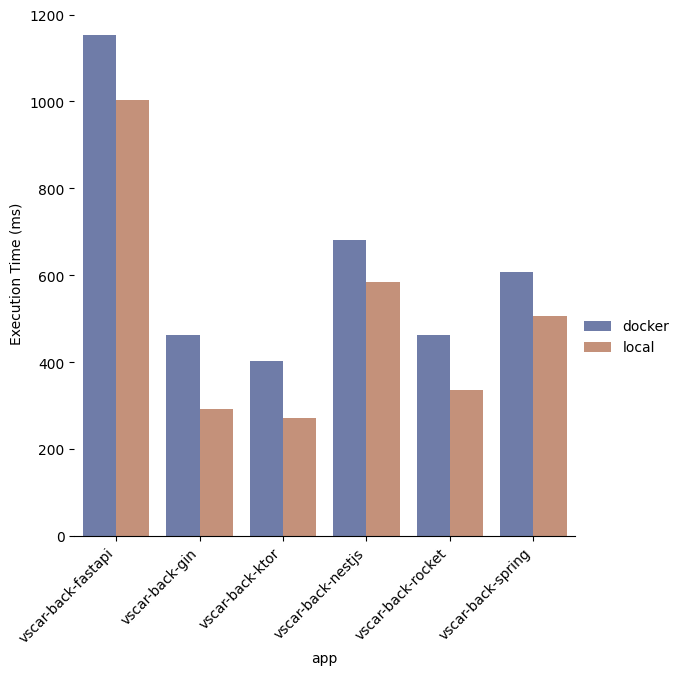

In [82]:
plot_and_print("loop_through_pages", parallel=True)

## Base on price_in_steps


Data for 'price_in_steps' Test Type:

     test_type                app  parallel server  exec_time
price_in_steps vscar-back-fastapi     False docker  45.773240
price_in_steps     vscar-back-gin     False docker  13.190574
price_in_steps    vscar-back-ktor     False docker  10.033934
price_in_steps  vscar-back-nestjs     False docker  10.597405
price_in_steps  vscar-back-rocket     False docker  11.849204
price_in_steps  vscar-back-spring     False docker   9.557815
price_in_steps vscar-back-fastapi     False  local  39.426307
price_in_steps     vscar-back-gin     False  local  13.027113
price_in_steps    vscar-back-ktor     False  local   9.665389
price_in_steps  vscar-back-nestjs     False  local   8.951375
price_in_steps  vscar-back-rocket     False  local  11.899188
price_in_steps  vscar-back-spring     False  local  20.869888


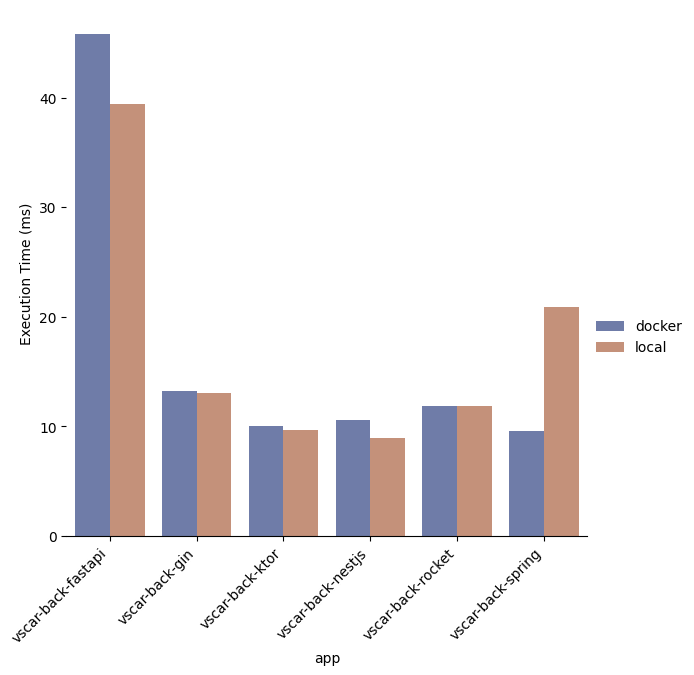

In [83]:
plot_and_print("price_in_steps", parallel=False)


Data for 'price_in_steps' Test Type:

     test_type                app  parallel server  exec_time
price_in_steps vscar-back-fastapi      True docker 137.432676
price_in_steps     vscar-back-gin      True docker  60.613660
price_in_steps    vscar-back-ktor      True docker  41.345933
price_in_steps  vscar-back-nestjs      True docker  95.908184
price_in_steps  vscar-back-rocket      True docker  43.747010
price_in_steps  vscar-back-spring      True docker  59.672377
price_in_steps vscar-back-fastapi      True  local 112.785479
price_in_steps     vscar-back-gin      True  local  21.746526
price_in_steps    vscar-back-ktor      True  local  16.384381
price_in_steps  vscar-back-nestjs      True  local  80.221674
price_in_steps  vscar-back-rocket      True  local  26.655117
price_in_steps  vscar-back-spring      True  local  44.522212


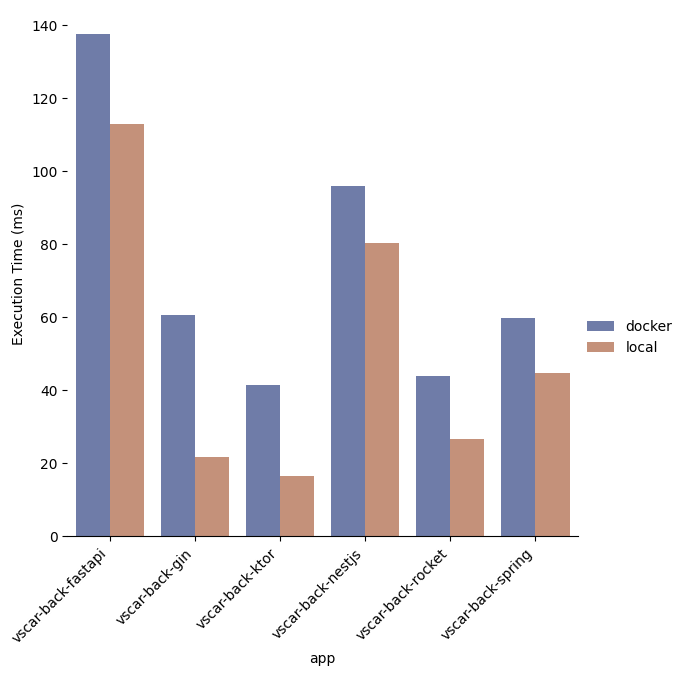

In [84]:
plot_and_print("price_in_steps", parallel=True)